<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

Импорт необходимых библиотек

In [4]:
import numpy as np
import torch
import torch.multiprocessing as mp
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm

from torch.cuda.amp import GradScaler, autocast

import seaborn
seaborn.set(palette='summer')
mp.set_start_method('spawn', force=True)
import os
os.environ["MKL_THREADING_LAYER"] = "GNU"

In [5]:
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /home/pavel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/pavel/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [6]:
device = torch.device("cuda")

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [8]:
# Загрузим датасет
dataset = load_dataset('imdb')

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [10]:
sentences = []
word_threshold = 32
train_dataset = dataset['train']
test_dataset = dataset['test']

for sample in train_dataset['text']:
    sentences.extend([sentence for sentence in sent_tokenize(sample) if len(sentence.split()) < word_threshold])


In [11]:
print("Всего предложений:", len(sentences))

Всего предложений: 219930


Посчитаем для каждого слова его встречаемость.

In [13]:
words = Counter()

for sentence in tqdm(sentences):
    for word in word_tokenize(sentence):
        words[word] += 1


100%|██████████| 219930/219930 [00:09<00:00, 24221.02it/s]


In [14]:
len(words.keys())

92516

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [16]:
vocab = set()
vocab_size = 40000
vocab.update(['<unk>', '<bos>', '<eos>', '<pad>'])
count = 0
for word in words.keys():
    vocab.add(word)
    count+=1
    if count == 40000:
        break


In [17]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [18]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [20]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [21]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(char, self.unk_id) for char in self.data[idx]] 
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [22]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [23]:

train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 8

train_dataloader = DataLoader(
    train_dataset,
    collate_fn=collate_fn_with_padding,
    batch_size=batch_size,
    num_workers=0
)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [26]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            logits = model(batch['input_ids'].to(device)).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].to(device).flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [28]:
from torch.amp import GradScaler, autocast


def train_model(model, criterion, train_dataloader, eval_dataloader, optimizer, num_epoch):
    model.train()
    losses = []
    perplexities = []
    scaler = GradScaler('cuda') 
    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch}:'):
            optimizer.zero_grad()
            with autocast('cuda'):
                logits = model(batch['input_ids'].to(device)).flatten(start_dim=0, end_dim=1)
                loss = criterion(logits, batch['target_ids'].to(device).flatten())
            scaler.scale(loss).backward()  
            scaler.step(optimizer)         
            scaler.update()   
            epoch_losses.append(loss.item())

        losses.append(sum(epoch_losses) / len(epoch_losses))
        perplexities.append(evaluate(model, criterion, eval_dataloader))

    return losses, perplexities


### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

In [30]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]\
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [31]:

model = LanguageModel(hidden_dim=256, vocab_size=len(vocab))
model = model.to(device)  
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [32]:
losses, perplexities = train_model(model, criterion, train_dataloader, eval_dataloader, optimizer, 5)

100%|██████████| 13746/13746 [01:11<00:00, 193.27it/s]


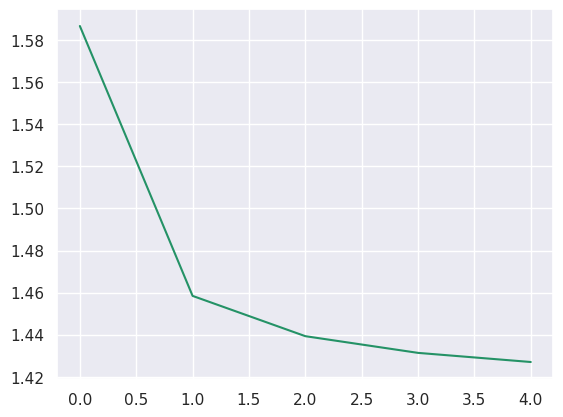

In [33]:
plt.plot(losses)
plt.show()

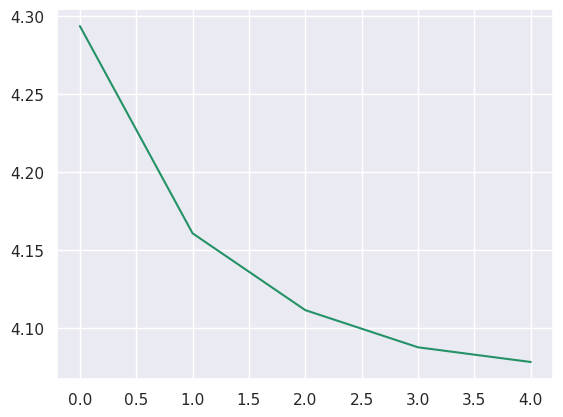

In [34]:
plt.plot(perplexities)
plt.show()

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

In [41]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, dropout = 0.1)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)
        output, _ = self.rnn(embeddings)
        output = self.dropout(self.linear(self.non_lin(output)))
        projection = self.projection(self.non_lin(output))

        return projection

model = LanguageModel(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

losses, perplexities = train_model(model, criterion, train_dataloader, eval_dataloader, optimizer, 5)

100%|██████████| 13746/13746 [01:23<00:00, 164.71it/s]


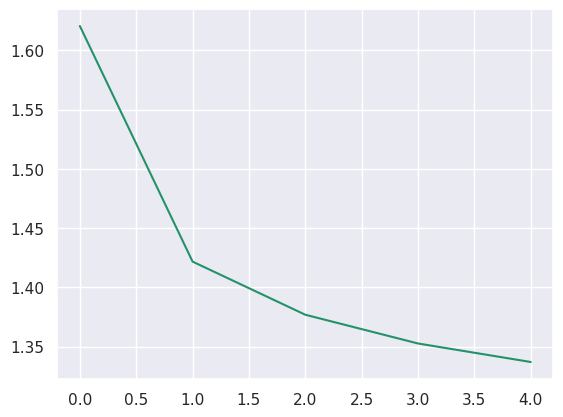

In [42]:
plt.plot(losses)
plt.show()

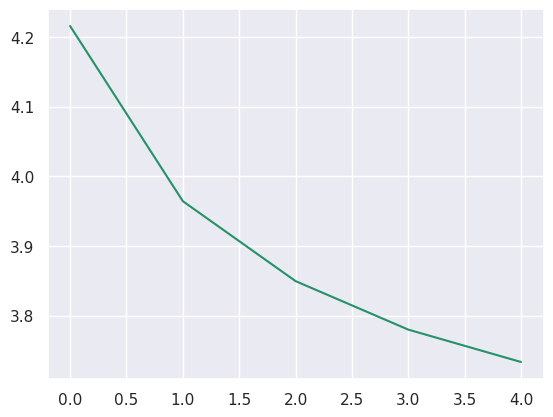

In [43]:
plt.plot(perplexities)
plt.show()

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

In [47]:
# В качестве первой модели взята RNN у которой для большой последовательности слов имеет место проблема затухания градиентов,
# но вот незадача, в самом начале мы поставили порог слов, т.е. мы специально выбираем большие (относительно) последовательности.
# Чтобы решить проблемы затухания градиентов, можно выбрать LSTM архитектуру, что я и сделал во втором эксперименте.
# Улучшений может быть довольно много, но самый очебидный путь - LSTM в две стороны, или увеличение количества слоев.